<a href="https://colab.research.google.com/github/kirannyaupane11/Wildfire-Detection-and-Classification-with-Satellite-Images/blob/main/Wildfire_Model_train_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 24200 images belonging to 2 classes.
Found 6050 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


757/757 ━━━━━━━━━━━━━━━━━━━━ 9055s 12s/step - accuracy: 0.8082 - loss: 0.4865 - val_accuracy: 0.8765 - val_loss: 0.3144


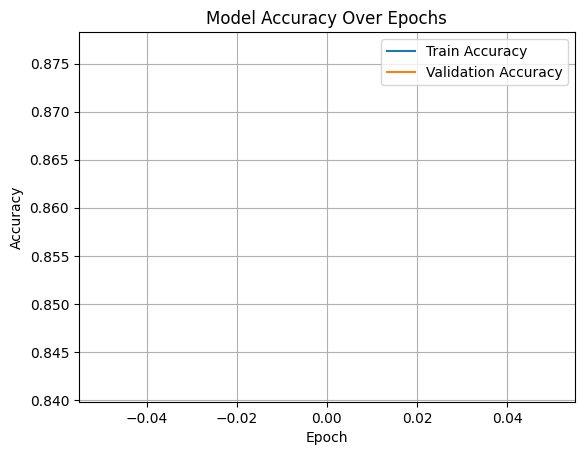

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import required libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# NEW: This will allow PIL to load truncated/corrupted images without crashing
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Step 3: Define paths and parameters
train_dir = '/content/drive/MyDrive/wildfire detection satellite images1/archive/train'
img_height, img_width = 224, 224
batch_size = 32
num_classes = 2
epochs = 1

# Step 4: Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Step 5: Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model to use pretrained weights
base_model.trainable = False

# Step 6: Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Step 7: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

# Step 9: Save the model
model.save('/content/drive/MyDrive/wildfire_detection_model_resnet50.h5')

# Step 10: Plot training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
#  Import necessary libraries
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Load the trained model
model_path = '/content/drive/MyDrive/wildfire_detection_model_resnet50.h5'
model = load_model(model_path)

# Define class labels (must match training)
class_indices = {'no wildfire': 0, 'wildfire': 1}
labels = {v: k for k, v in class_indices.items()}

# Path to the test images folder
test_dir = '/content/drive/MyDrive/wildfire detection satellite images1/archive/testing'

# Function to preprocess and predict a single image
def classify_image(image_path):
    try:
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_array)
        predicted_class = labels[np.argmax(pred)]
        confidence = pred[0][np.argmax(pred)] * 100
        return predicted_class, confidence
    except Exception as e:
        print(f"⚠️ Error processing {image_path}: {e}")
        return None, None

#  Loop through all images and classify
print("🔥 Wildfire Detection Results:\n")
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            result, confidence = classify_image(image_path)
            if result:
                status = "🔥 Wildfire detected" if result == 'wildfire' else "❌ No wildfire detected"
                print(f"{file}: {status} (Confidence: {confidence:.2f}%)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


🔥 Wildfire Detection Results:

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
-64.896,49.1447.jpg: 🔥 Wildfire detected (Confidence: 76.93%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
-63.84004,49.79766.jpg: 🔥 Wildfire detected (Confidence: 75.61%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
-64.384,48.64359.jpg: 🔥 Wildfire detected (Confidence: 78.27%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
-63.80516,50.32195.jpg: ❌ No wildfire detected (Confidence: 59.89%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
-63.89671,50.8738.jpg: 🔥 Wildfire detected (Confidence: 76.18%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
-63.62306,50.25719.jpg: 🔥 Wildfire detected (Confidence: 74.57%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
-64.4181,48.78597.jpg: 🔥 Wildfire detected (Confidence: 73.23%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
-64.1526,50.27158.jpg: 🔥 Wildfire detected (Confidence: 71.92%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
-63.32182,51.31475.jpg: 🔥 Wildfire detected (Confidence: 73.69%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
-6